In [1]:
%config Completer.use_jedi = False

In [2]:
import torch
import torch.nn as nn
from torchsummary import summary
print(torch.__version__)

1.9.1+cu111


# ResNet

### BasicBlock

In [3]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or (in_planes != planes):
            self.shortcut = self._make_shortcut(in_planes, planes, stride)
            
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out
    
    def _make_shortcut(self, in_planes, planes, stride):
        layers = []
        layers += [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
        layers += [nn.BatchNorm2d(planes)]
        
        return nn.Sequential(*layers)

block1 = BasicBlock(64, 64, 2)
block2 = BasicBlock(64, 128, 2)
block3 = BasicBlock(64, 64, 1)

block3

BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (shortcut): Sequential()
)

### Bottlenect

In [4]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)    
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != (planes * self.expansion):
            self.shortcut = self._make_shortcut(in_planes, planes, stride=stride)
    
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(identity)
        
        out = self.relu(out)
        
        return out
    
    def _make_shortcut(self, in_planes, planes, stride):
        layers = []
        layers += [nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False)]
        layers += [nn.BatchNorm2d(planes * self.expansion)]
        
        return nn.Sequential(*layers)
    

block1 = Bottleneck(64, 64, 1)

### ResNet-00

In [5]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.layer1 = self._make_layers(block, num_blocks[0], 64, 1)
        self.layer2 = self._make_layers(block, num_blocks[1], 128, 2)
        self.layer3 = self._make_layers(block, num_blocks[2], 256, 2)
        self.layer4 = self._make_layers(block, num_blocks[3], 512, 2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.in_planes, num_classes)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x   
    
    def _make_layers(self, block, num_block, planes, stride):
        strides = [stride] + [1]*(num_block-1)
        
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride=stride))
            self.in_planes = planes * block.expansion
        
        return nn.Sequential(*layers)
    

### Check

In [6]:
from torchvision.models import resnet34, resnet50

resnet34_my = ResNet(BasicBlock, [3,4,6,3])
resnet34_gt = resnet34(pretrained=False) 

resnet50_my = ResNet(Bottleneck, [3, 4, 6, 3])
resnet50_gt = resnet50(pretrained=False)

# Layer 개수 확인
print(len(resnet34_my.state_dict()))
print(len(resnet34_gt.state_dict()))

print(len(resnet50_my.state_dict()))
print(len(resnet50_gt.state_dict()))

218
218
320
320


In [7]:
resnet50_my

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), b

# Dataset

In [8]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt

In [9]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def collate_fn(batch):
    return tuple(zip(*batch))

data_path = r'C:\Users\gjust\Documents\Github\data\dogs-vs-cats\train'
datasets = ImageFolder(root=data_path, transform=transform)

trainset, testset = random_split(datasets, [20000, 5000])
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)
test_loader = DataLoader(testset, batch_size=2)
print(len(trainset))
print(len(testset))

20000
5000


# 시각화

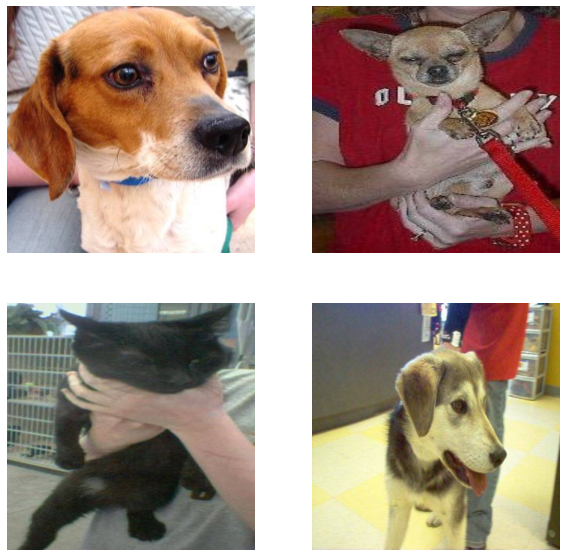

In [10]:
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                             std=[1/0.229, 1/0.224, 1/0.225])

def show_img(dataloader, batch_size=4):
    images, labels = iter(dataloader).next()
    
    plt.figure(figsize=(10,10))
    for i, img in enumerate(images):
        img = inv_normalize(img)
        img = img.permute(1,2,0)
        plt.subplot(2,2,i+1)
        plt.imshow(img)
        plt.axis('off')

show_img(train_loader)

# Model

In [11]:
resnet50 = ResNet(Bottleneck, [3, 4, 6, 3])
summary(resnet50.to('cuda'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]           4,096
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              ReLU-6         [-1, 64, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          36,864
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 256, 112, 112]          16,384
      BatchNorm2d-11        [-1, 256, 112, 112]             512
           Conv2d-12        [-1, 256, 112, 112]          16,384
      BatchNorm2d-13        [-1, 256, 112, 112]             512
             ReLU-14        [-1, 256, 1

# GPU

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Optim

In [13]:
import torch.optim as optim
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=0.00001)
loss_func = nn.CrossEntropyLoss()

# Train

In [14]:
EPOCH = 100

train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []
for e in range(EPOCH):
    
    resnet50.train()
    train_loss = 0
    train_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        if i == 3:
            break
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet50(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() / images.size(0)
        train_correct += (outputs.argmax(axis=1) == labels).sum().item() / images.size(0)
        print(f'\r Train[{e+1}/{EPOCH}] --- Iter[{i+1}/{len(train_loader)}]' \
                f' --- Loss: {train_loss:0.4f} --- Acc: {train_correct/images.size(0):0.4f}', end='')
    print('')   
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct / len(train_loader.dataset))
    
    
    resnet50.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            if i == 3:
                break
            images, labels = images.to(device), labels.to(device)

            outputs = resnet50(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item() / images.size(0)
            test_correct += (outputs.argmax(axis=1) == labels).sum().item()
            print(f'\r Test[{e+1}/{EPOCH}] --- Iter[{i+1}/{len(test_loader)}]' \
            f' --- Loss: {test_loss:0.4f} --- Acc: {test_correct/images.size(0):0.4f}', end='')
    
    print('')
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct / len(test_loader.dataset))

 Train[1/100] --- Iter[3/5000] --- Loss: 4.7273 --- Acc: 0.2500
 Test[1/100] --- Iter[3/2500] --- Loss: 9.5808 --- Acc: 1.0000
 Train[2/100] --- Iter[3/5000] --- Loss: 1.9057 --- Acc: 0.3125
 Test[2/100] --- Iter[3/2500] --- Loss: 6.8423 --- Acc: 1.0000
 Train[3/100] --- Iter[2/5000] --- Loss: 0.6469 --- Acc: 0.1250

KeyboardInterrupt: 

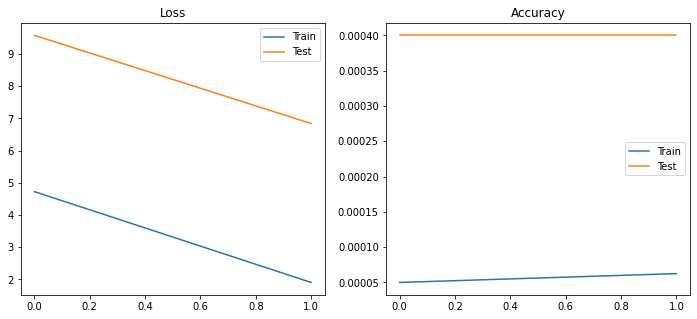

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_list)
plt.plot(test_loss_list)
plt.title('Loss')
plt.legend(['Train', 'Test'])

plt.subplot(1,2,2)
plt.plot(train_acc_list)
plt.plot(test_acc_list)
plt.title('Accuracy')
plt.legend(['Train', 'Test'])